In [1]:
import os
import re
import zipfile
import shutil
import pathlib

In [2]:
from fastai import * 
from fastai.vision import *

In [3]:
# set batchsize
bs = 64

### Extracting Data

In [ ]:
path = pathlib.Path().absolute()

In [ ]:
import zipfile

zip_path = Path('/home/jupyter/victor_projects/chest_xrays/data/xray_data.zip')
extract_path = Path('/home/jupyter/victor_projects/chest_xrays/data')

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
shutil.move('/home/jupyter/victor_projects/chest_xrays/data/xray_data',\
            '/home/jupyter/victor_projects/chest_xrays')

### Creating Dataset

In [4]:
path = Path('/home/jupyter/victor_projects/chest_xrays/data')

np.random.seed(7)

In [5]:
data = ImageDataBunch.from_folder(path,
                                  test='test',
                                  valid_pct=0.2,
                                  no_check=True,
                                  ds_tfms=get_transforms(),
                                  size=224,
                                  bs=bs).normalize(imagenet_stats)

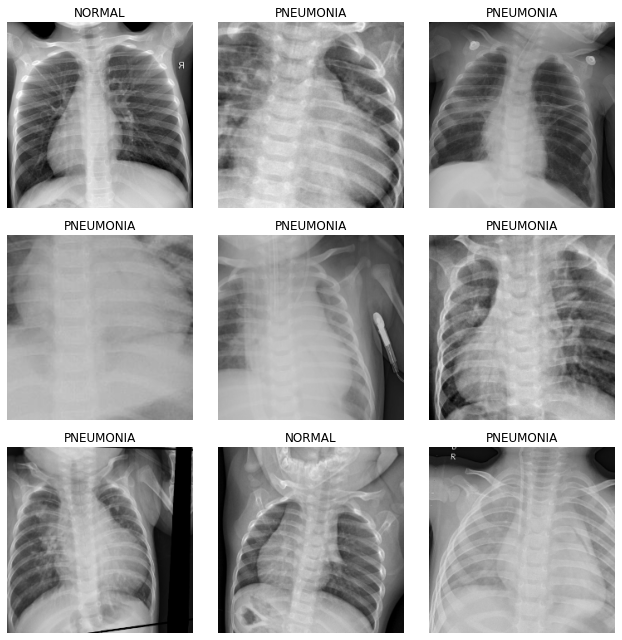

In [6]:
data.show_batch(rows=3, figsize=(9,9))

In [7]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds), len(data.test_ds)

(['NORMAL', 'PNEUMONIA'], 2, 4186, 1046, 624)

### Creating & Training Model
There are two kinds of pneumonia: bacterial and viral. For now both of these pneumonia are aggregated into the "pneumonia" label. I will be utilizing the ResNet 50 architecture CNN.

In [8]:
learner = cnn_learner(data,
                      models.resnet50,
                      metrics=[accuracy, error_rate],
                      model_dir='/home/jupyter/victor_projects/chest_xrays/models')

In [9]:
learner.save('empty')

In [10]:
learner.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.450421,0.494417,0.911090,0.088910,01:14
1,0.261382,0.269933,0.931166,0.068834,01:02
2,0.175186,0.181393,0.945507,0.054493,01:01
3,0.145939,0.149459,0.952199,0.047801,01:01


In [11]:
learner.save('stage_1')

In [12]:
# before unfreezing test
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


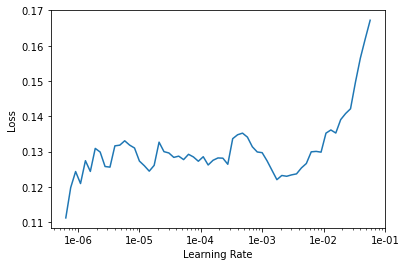

In [13]:
learner.recorder.plot()

In [14]:
# testing with pre-frozen learning rate
learner.fit_one_cycle(7, max_lr=slice(8e-06,8e-05))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.120826,0.168347,0.945507,0.054493,01:04
1,0.104987,0.173919,0.947419,0.052581,01:06
2,0.121737,0.179861,0.946463,0.053537,01:03
3,0.114267,0.174081,0.947419,0.052581,01:03
4,0.114828,0.183689,0.944551,0.055449,01:02
5,0.103727,0.157094,0.952199,0.047801,01:01
6,0.113804,0.161973,0.951243,0.048757,01:02


In [15]:
learner.save('stage_2_frozen')

In [16]:
learner.load('stage_1')

Learner(data=ImageDataBunch;

Train: LabelList (4186 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
PNEUMONIA,PNEUMONIA,PNEUMONIA,PNEUMONIA,PNEUMONIA
Path: /home/jupyter/victor_projects/chest_xrays/data;

Valid: LabelList (1046 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
PNEUMONIA,NORMAL,PNEUMONIA,PNEUMONIA,PNEUMONIA
Path: /home/jupyter/victor_projects/chest_xrays/data;

Test: LabelList (624 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /home/jupyter/victor_projects/chest_xrays/data, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(i

In [17]:
learner.unfreeze()

In [18]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


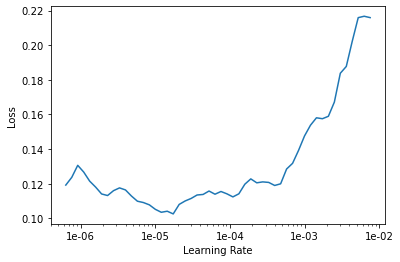

In [19]:
learner.recorder.plot()

In [23]:
learner.fit_one_cycle(7, max_lr=slice(5e-05,1e-03/5))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.109242,0.169297,0.955067,0.044933,01:03
1,0.107480,0.254864,0.938815,0.061185,01:03
2,0.097162,0.105590,0.965583,0.034417,01:02
3,0.082135,0.074769,0.978011,0.021989,01:02
4,0.054730,0.158392,0.961759,0.038241,01:02
5,0.044987,0.115851,0.968451,0.031549,01:03
6,0.035352,0.109911,0.970363,0.029637,01:03


In [24]:
learner.save('stage_2')

## Splitting "pneumonia" class into "bacterial" and "viral"

Since data is not organized into "bacterial" and "viral" directories, we will use a regular expression to extract them.

Plan: move all data into one folder and create my own train/valid/test splits then use RegEx to create labels

### Deleting and organizing directories

In [34]:
# shutil.rmtree(Path('/home/jupyter/victor_projects/chest_xrays/data2'))

In [35]:
# copy = Path('/home/jupyter/victor_projects/chest_xrays/data')
# dest = Path('/home/jupyter/victor_projects/chest_xrays/data2')

# shutil.copytree(copy, dest)

PosixPath('/home/jupyter/victor_projects/chest_xrays/data2')

In [42]:
# # Move all folders out of NORMAL, PNEUMONIA and into data2
# # CAUTION: Ran this cell multiple times with different folder!

# orig = '/home/jupyter/victor_projects/chest_xrays/data2/val/NORMAL'
# dest = '/home/jupyter/victor_projects/chest_xrays/data2'

# for i in os.listdir(orig):
#     shutil.copy(os.path.join(orig, i), dest)
    
# shutil.rmtree(orig)

In [ ]:
# # CAUTION: Ran this cell multiple times with different folder!

# folder = '/home/jupyter/victor_projects/chest_xrays/data2/test'

# shutil.rmtree(folder)

### Regular Expression Extraction
Looking through the data, I notice that the "pneumonia" lung pictures are labelled "personXXX_bacteria_XXX.jpeg" or "personXXX_virus_XXX.jpeg" denoting the label. Whereas the "normal" lung picture are either labelled "IM-XXX-XXX.jpeg" or "NORMAL2-IM-XXXX-XXXX.jpeg" where "X" is some number. For example "IM-0085-0001.jpeg" or "NORMAL2-IM-0692-0001.jpeg". There are also "normal" lung pictures with more numbers after the "IM" or "NORMAL2". Therefore I will handle this with an "else" statement after my regular expression captures "virus" or "bacteria".

In [4]:
path = pathlib.Path().absolute()

In [5]:
path.ls()

[PosixPath('/home/jupyter/victor_projects/chest_xrays/data'),
 PosixPath('/home/jupyter/victor_projects/chest_xrays/chest_xray.ipynb'),
 PosixPath('/home/jupyter/victor_projects/chest_xrays/.ipynb_checkpoints'),
 PosixPath('/home/jupyter/victor_projects/chest_xrays/data2'),
 PosixPath('/home/jupyter/victor_projects/chest_xrays/models'),
 PosixPath('/home/jupyter/victor_projects/chest_xrays/helper.ipynb')]

In [6]:
path_img = path/'data2'

In [7]:
fn_paths = get_image_files(path_img)
fn_paths[:11]

[PosixPath('/home/jupyter/victor_projects/chest_xrays/data2/person1539_virus_2679.jpeg'),
 PosixPath('/home/jupyter/victor_projects/chest_xrays/data2/person1650_virus_2854.jpeg'),
 PosixPath('/home/jupyter/victor_projects/chest_xrays/data2/NORMAL2-IM-0799-0001.jpeg'),
 PosixPath('/home/jupyter/victor_projects/chest_xrays/data2/person94_bacteria_456.jpeg'),
 PosixPath('/home/jupyter/victor_projects/chest_xrays/data2/person1263_bacteria_3221.jpeg'),
 PosixPath('/home/jupyter/victor_projects/chest_xrays/data2/person334_bacteria_1542.jpeg'),
 PosixPath('/home/jupyter/victor_projects/chest_xrays/data2/person1453_virus_2485.jpeg'),
 PosixPath('/home/jupyter/victor_projects/chest_xrays/data2/IM-0546-0001.jpeg'),
 PosixPath('/home/jupyter/victor_projects/chest_xrays/data2/person1144_bacteria_3089.jpeg'),
 PosixPath('/home/jupyter/victor_projects/chest_xrays/data2/person1696_bacteria_4495.jpeg'),
 PosixPath('/home/jupyter/victor_projects/chest_xrays/data2/IM-0538-0001.jpeg')]

In [8]:
# Create custom regular expression function since three different formats of path names

def get_labels(path):
    pat = re.search('/person[\d]+_(virus|bacteria)_[\d]+\.jpeg$', str(path))
    if (pat):
        return pat[1]
    else:
        return 'normal'

In [9]:
np.random.seed(2)
data = ImageDataBunch.from_name_func(path_img, fn_paths, 
                                     label_func=get_labels,
                                     ds_tfms=get_transforms(),
                                     size=224,bs=bs).normalize(imagenet_stats)

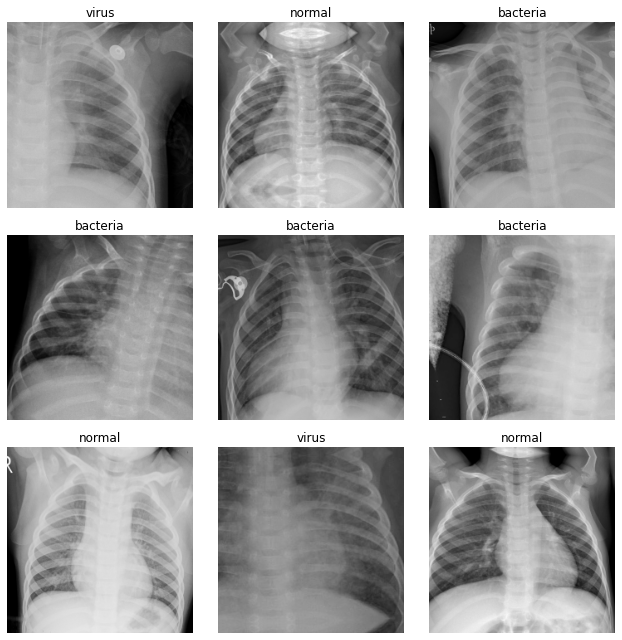

In [10]:
data.show_batch(rows=3,figsize=(9,9))

In [11]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['bacteria', 'normal', 'virus'], 3, 4685, 1171)

## Training Model
I will utilize transfer learning by using my pre-trained binary classification model.

In [12]:
# # Changing data for learner
# learner.data = data
# learner.fit_one_cycle(4)
# # Ran into issue with this code CUDA error: device-side assert triggered

In [13]:
learner = cnn_learner(data,
                      models.resnet50,
                      metrics=[accuracy, error_rate],
                      model_dir='/home/jupyter/victor_projects/chest_xrays/models')

In [14]:
learner.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.129449,0.885409,0.750640,0.249360,01:21
1,0.784510,0.511199,0.796755,0.203245,01:01
2,0.615974,0.484880,0.798463,0.201537,01:01
3,0.547557,0.472915,0.792485,0.207515,01:00


In [15]:
learner.save('multiclass_stage1')

In [16]:
learner.unfreeze()

In [16]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


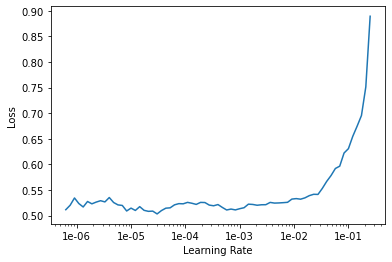

In [17]:
learner.recorder.plot()

In [19]:
learner.fit_one_cycle(11, max_lr=slice(1e-05,1e-02))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.531030,0.487667,0.803587,0.196413,01:00
1,0.603407,0.604586,0.768574,0.231426,01:00
2,0.636870,0.547051,0.802733,0.197267,01:00
3,0.613644,0.577810,0.808711,0.191289,00:59
4,0.561030,0.448667,0.811272,0.188728,01:00
5,0.516873,0.495563,0.823228,0.176772,01:00
6,0.502146,0.444710,0.817250,0.182750,01:00
7,0.475600,0.437961,0.824936,0.175064,01:01
8,0.449636,0.421555,0.830060,0.169940,01:01
9,0.432732,0.403347,0.839453,0.160547,01:01


In [20]:
learner.save('multiclass_stage2')